In [1]:
# Import useful packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
import time

# Import ML packages 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier	
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier		

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

from xgboost import XGBClassifier

from tpot import TPOTClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import my functions 

from my_toolkit import *

os.chdir('/Users/camilleepitalon/Documents/DSB/11_machine_learning_2/Project')
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test-full.csv')

/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Feature Engineering

- Create new features based on existing ones (linear combinaisons)
- Check feature importance and drop unsignificant ones

In [2]:
# Separate numerical and dummies columns
all_columns = list(df_train.columns)
columns = [col for col in df_test.columns if col != 'Id']
num_columns = [col for col in columns if 'Soil_Type' not in col and 'Wilderness_Area' not in col and 'Id' not in col]
dummy_cols = [col for col in columns if col not in num_columns and 'Id' not in col]
wilder_columns = [col for col in df_train.columns if 'Wilderness_Area' in col]
soil_columns = [col for col in df_train.columns if 'Soil_Type' in col]

print('-->', len(columns), 'features (+ the ID column)')
print('• ', len(num_columns), 'numerical features:\n', num_columns)
print('• ', len(dummy_cols), 'binary features:\n', dummy_cols)

--> 54 features (+ the ID column)
•  10 numerical features:
 ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
•  44 binary features:
 ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [16]:
# Class parameters
df_train = df_train
df_test = df_test
model = None
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = None
random_state = 2

preprocessing_class = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state) 

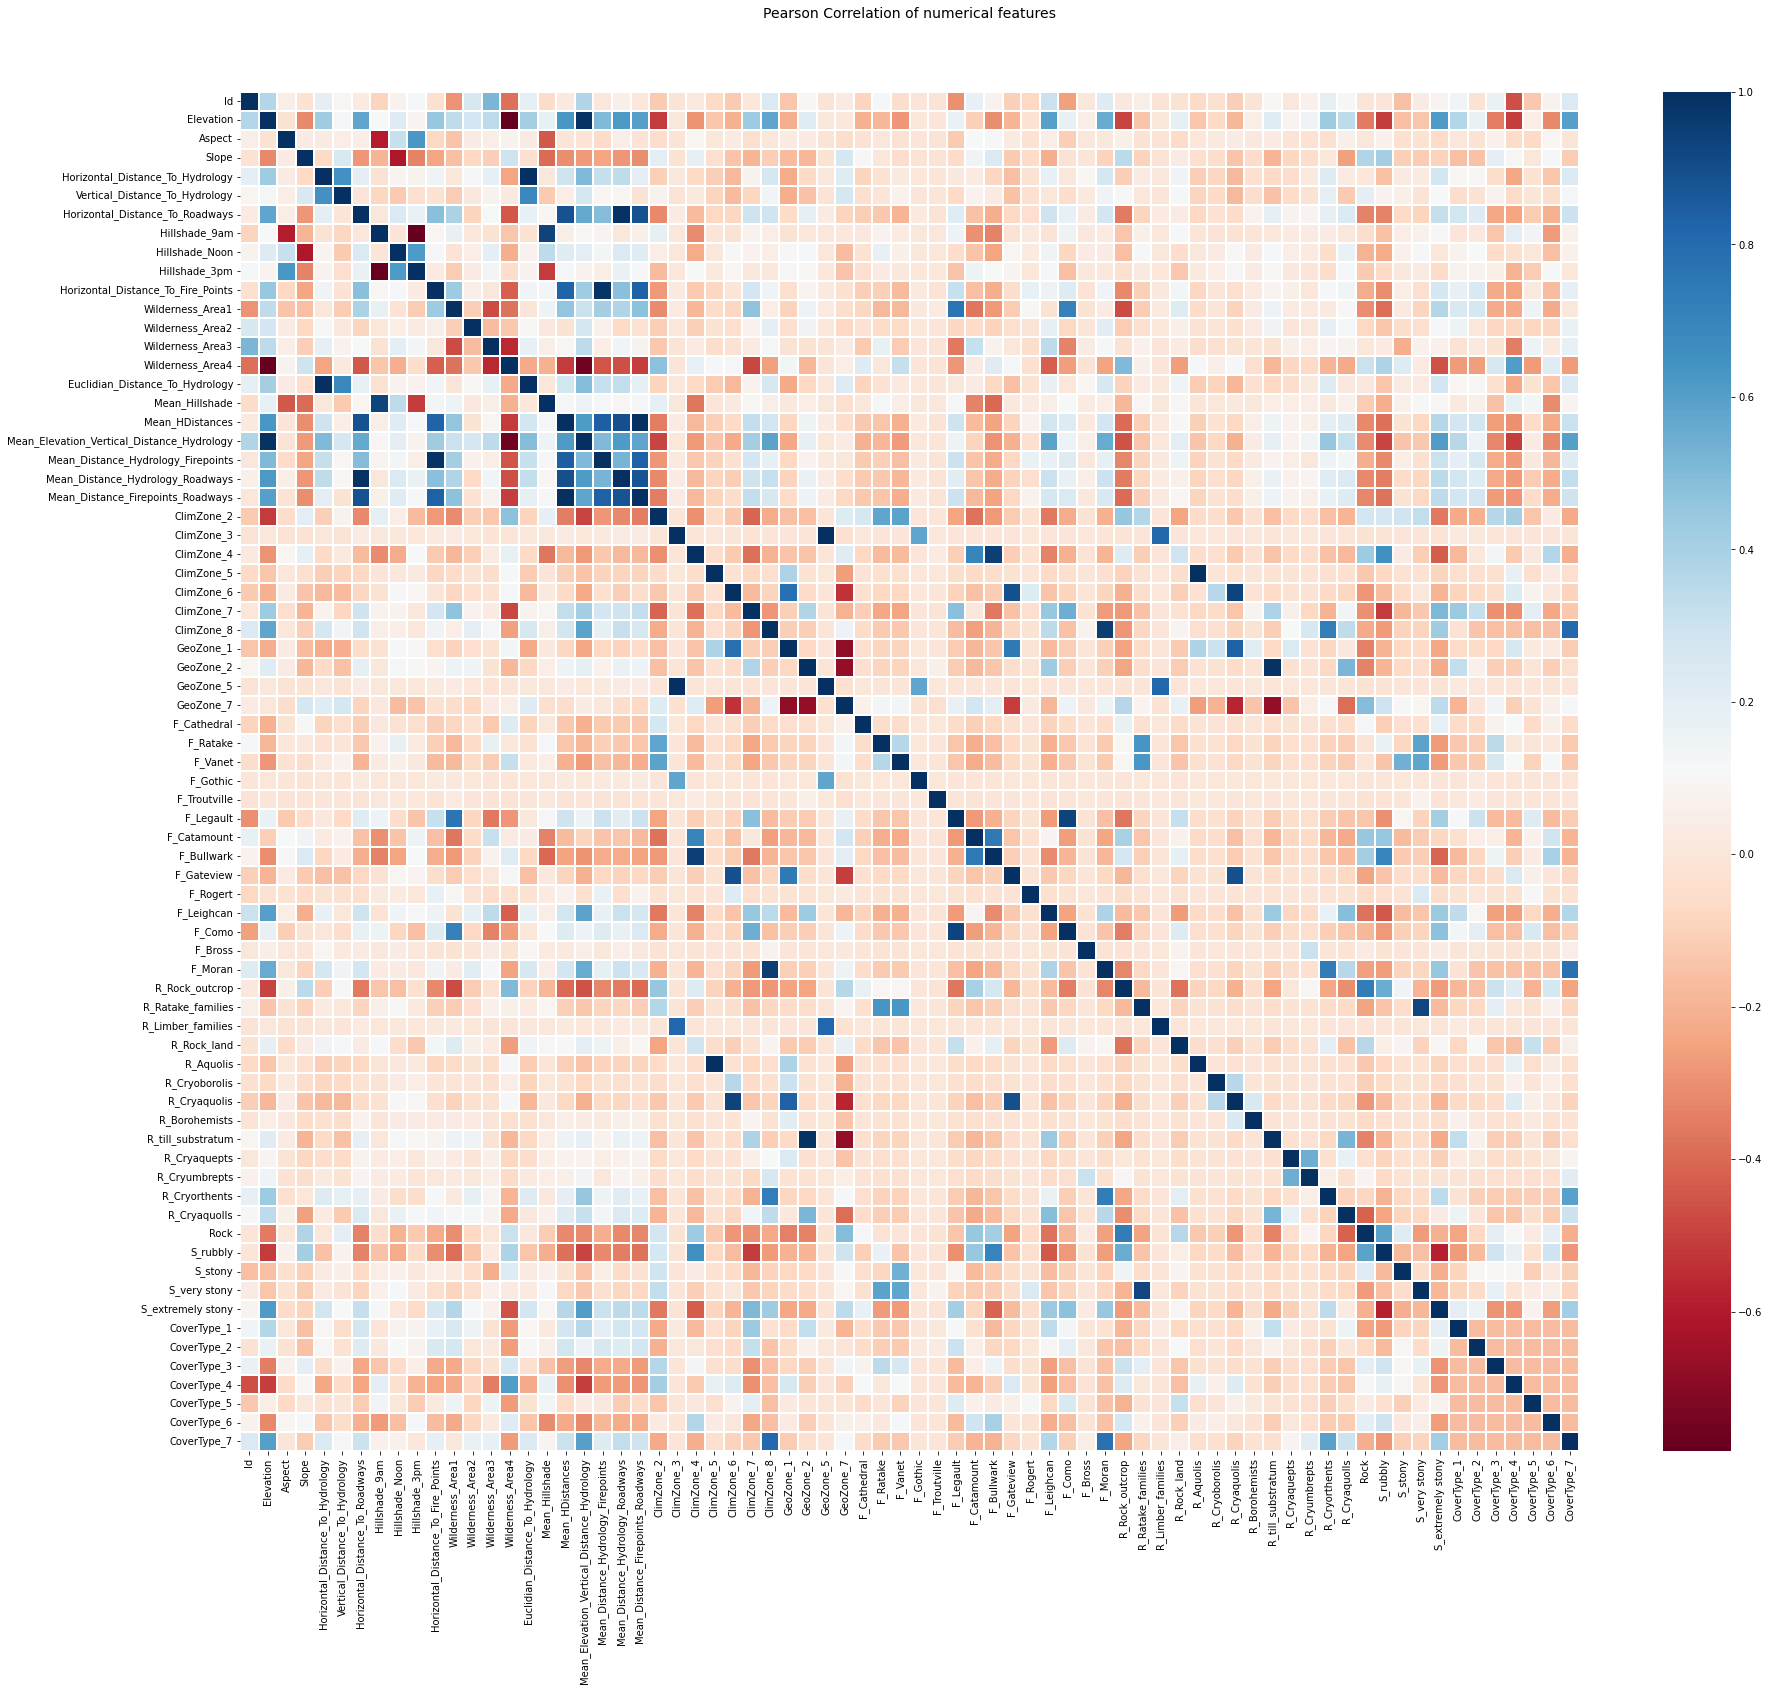

In [17]:
cl = preprocessing_class
df_enriched = cl.enrich_data(df_train)
df_enriched_enc = one_hot_encode(df_enriched, column_of_interest='Cover_Type', new_columns_prefix='CoverType')

# Plot Pearson Correlation of numerical features
plt.figure(figsize=(30,25))
sns.heatmap(df_enriched_enc.corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=plt.cm.RdBu, linecolor='white', annot=False)
plt.title('Pearson Correlation of numerical features', y=1.05, size=14);

Looking at this chart, we see that many features have no impact onf the CoverTypes (same color for all of them). Let's remove them.

In [18]:
# Class parameters
df_train = df_train
df_test = df_test
model = None
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

preprocessing_class = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state) 

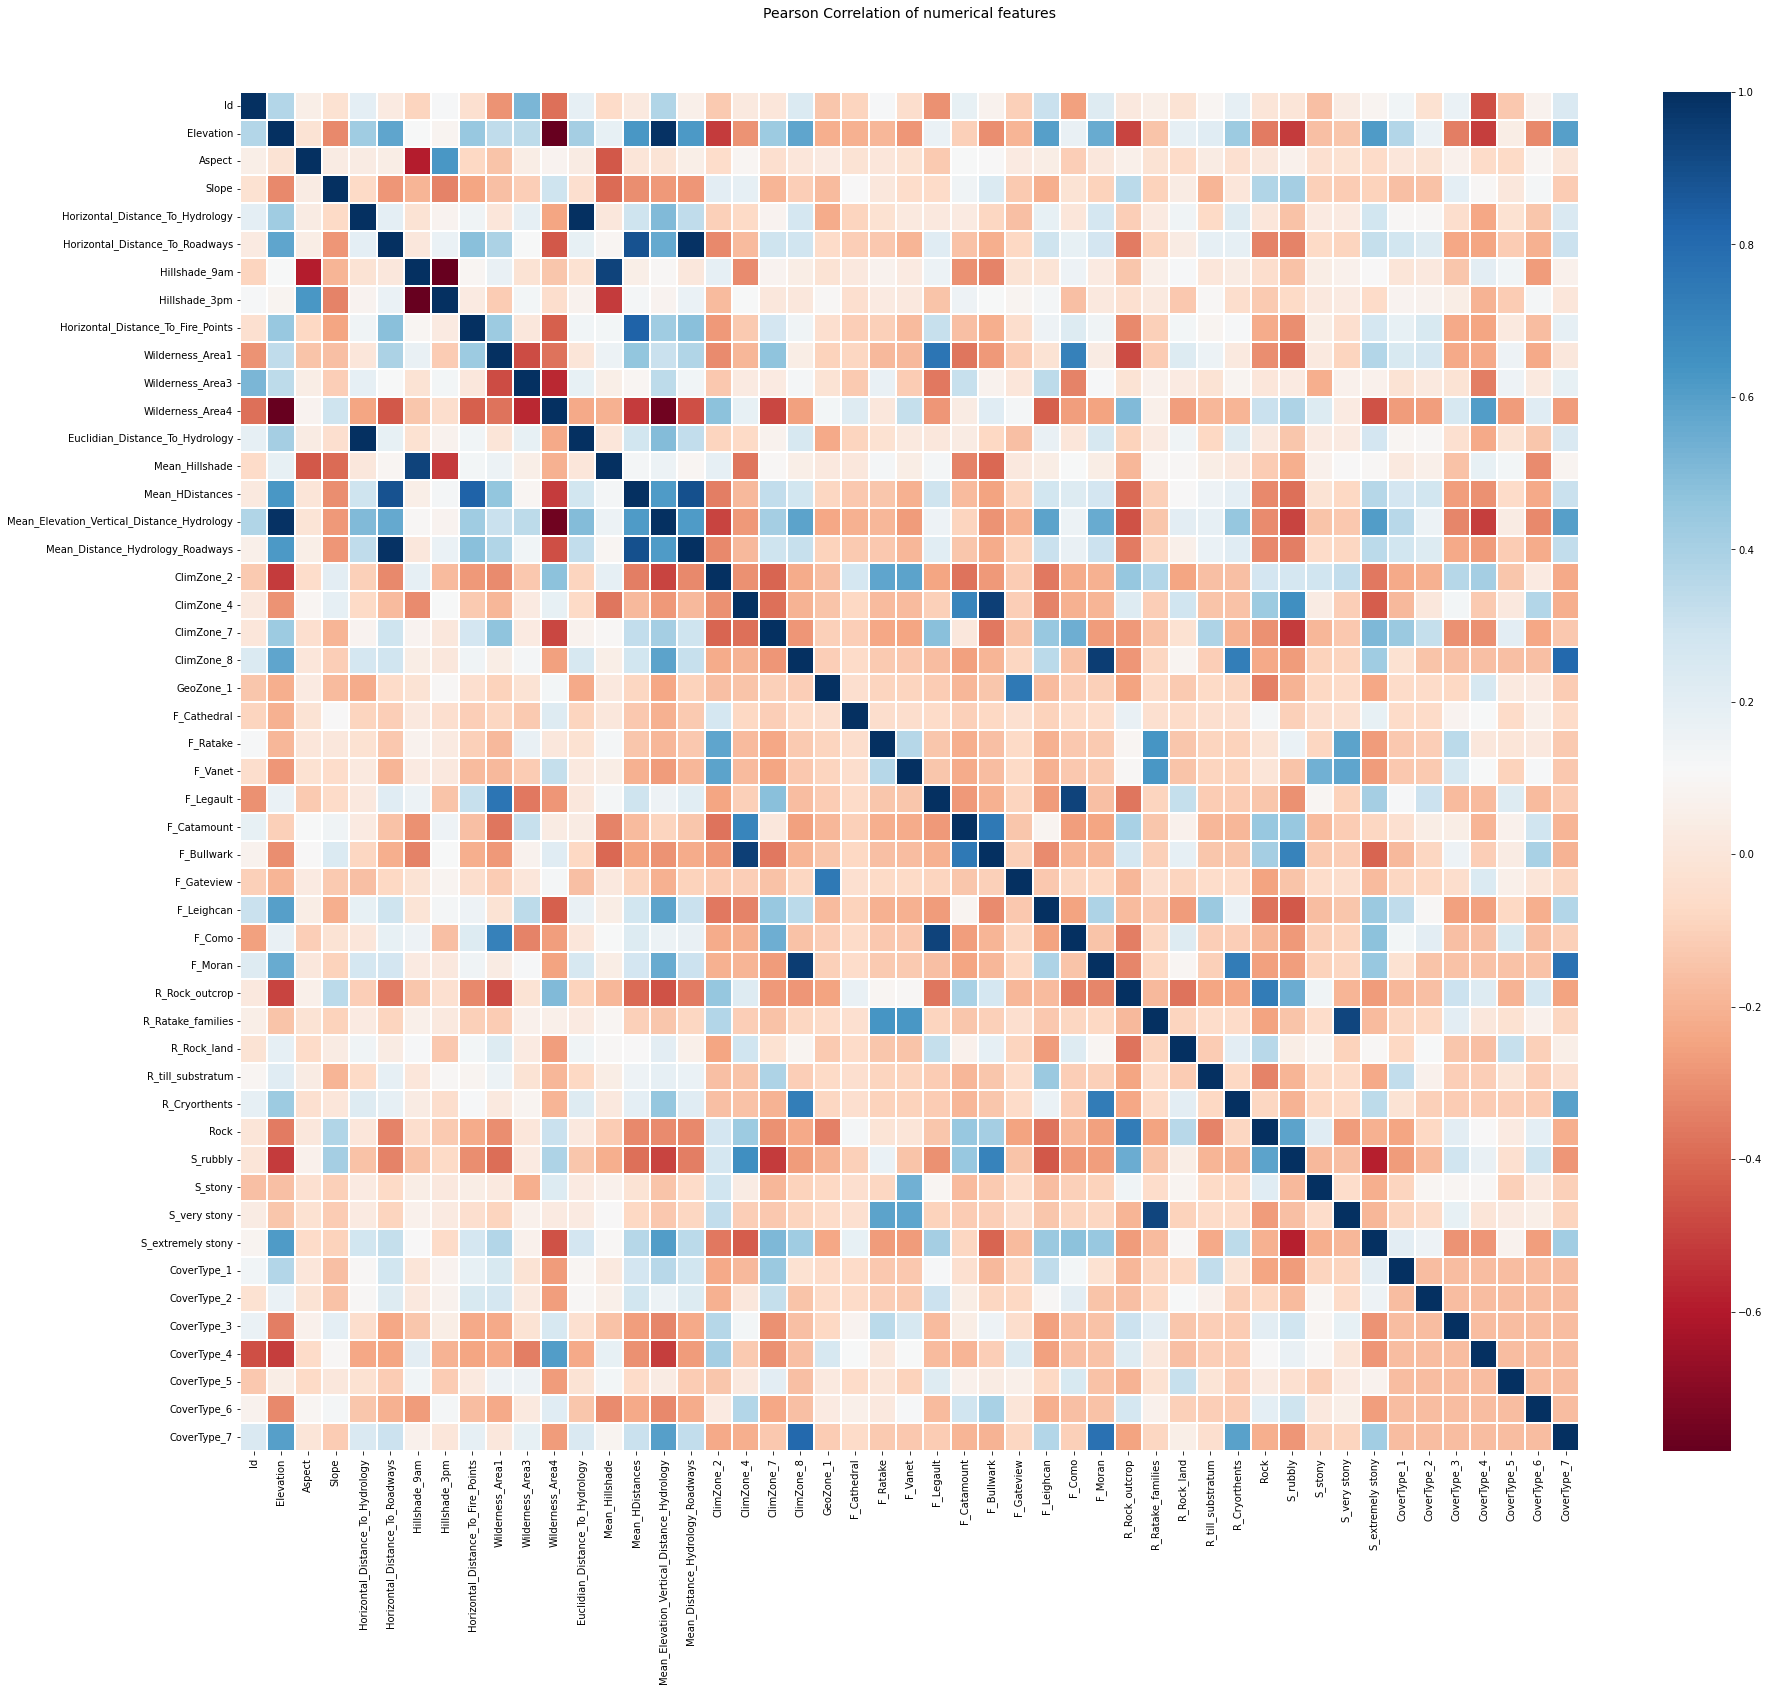

In [21]:
insignificant_features = ['Vertical_Distance_To_Hydrology','Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2','GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
significant_features = [col for col in df_enriched_enc if col not in insignificant_features]
# Plot Pearson Correlation of numerical features
plt.figure(figsize=(30,25))
sns.heatmap(df_enriched_enc[significant_features].corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=plt.cm.RdBu, linecolor='white', annot=False)
plt.title('Pearson Correlation of numerical features', y=1.05, size=14);

### Modelling

In [6]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
#model = LogisticRegression()
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

In [7]:
cl = modelling_class
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 52
   -- took 51.75 sec
training model...
   -- took 0.86 sec
predicting test_set...
   -- took 2.54 sec
exporting file...
computing local metrics...
   -- took 2.51 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 58.4
- Accuracy: 0.8991
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,363,55,0,0,5,0,20
pred2,59,313,11,0,23,8,3
pred3,0,1,364,13,3,30,0
pred4,0,0,4,429,0,3,0
pred5,0,14,2,0,395,2,0
pred6,0,1,28,12,3,414,0
pred7,5,0,0,0,0,0,441


In [11]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = None
random_state = 2

modelling_class2 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

In [12]:
cl = modelling_class2
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 65
   -- took 52.66 sec
training model...
   -- took 13.8 sec
predicting test_set...
   -- took 20.24 sec
exporting file...
computing local metrics...
   -- took 13.0 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': None, 'random_state': 2}
- Execution time: 100.33
- Accuracy: 0.9021
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,361,54,0,0,3,0,25
pred2,60,319,11,0,18,7,2
pred3,0,2,371,13,2,23,0
pred4,0,0,6,428,0,2,0
pred5,1,9,2,0,399,2,0
pred6,0,0,31,13,2,412,0
pred7,8,0,0,0,0,0,438


In [23]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['Vertical_Distance_To_Hydrology','Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2','GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
random_state = 2

modelling_class3 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class3
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 42
   -- took 54.78 sec
training model...
   -- took 11.46 sec
predicting test_set...
   -- took 19.99 sec
exporting file...
computing local metrics...
   -- took 11.08 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['Vertical_Distance_To_Hydrology', 'Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2', 'GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 97.94
- Accuracy: 0.9005
- Confusion m

,true1,true2,true3,true4,true5,true6,true7
pred1,364,49,0,0,4,0,26
pred2,60,318,11,0,19,7,2
pred3,0,2,369,11,2,27,0
pred4,0,0,7,426,0,3,0
pred5,1,12,2,0,396,2,0
pred6,0,0,29,13,2,414,0
pred7,10,0,0,0,0,0,436


In [24]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = False
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['Vertical_Distance_To_Hydrology','Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2','GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
random_state = 2

modelling_class3 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class3
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 37
   -- took 53.23 sec
training model...
   -- took 9.13 sec
predicting test_set...
   -- took 19.88 sec
exporting file...
computing local metrics...
   -- took 8.56 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': False, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['Vertical_Distance_To_Hydrology', 'Hillshade_Noon', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Firepoints_Roadways', 'Wilderness_Area2', 'ClimZone_3', 'ClimZone_5', 'ClimZone_6', 'GeoZone_2', 'GeoZone_5', 'GeoZone_7', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 91.5
- Accuracy: 0.8998
- Confusion mat

,true1,true2,true3,true4,true5,true6,true7
pred1,362,50,0,0,5,0,26
pred2,55,323,10,0,18,9,2
pred3,0,2,367,15,3,24,0
pred4,0,0,7,426,0,3,0
pred5,0,16,2,0,393,2,0
pred6,0,1,31,10,3,413,0
pred7,9,0,0,0,0,0,437


In [25]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = False
add_climate = False
add_geographic = False
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls']
random_state = 2

modelling_class4 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class4
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 35
   -- took 55.09 sec
training model...
   -- took 9.99 sec
predicting test_set...
   -- took 20.18 sec
exporting file...
computing local metrics...
   -- took 10.04 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': False, 'add_climate': False, 'add_geographic': False, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 95.96
- Accuracy: 0.9028
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,363,52,0,0,3,0,25
pred2,55,321,11,0,20,7,3
pred3,0,2,375,12,2,20,0
pred4,0,0,6,428,0,2,0
pred5,1,15,2,0,393,2,0
pred6,0,0,33,10,3,412,0
pred7,8,0,0,0,0,0,438


In [26]:
# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512, n_jobs=-1)
model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = True
columns_to_drop = None
random_state = 2

modelling_class4 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class4
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 105
   -- took 52.76 sec
training model...
   -- took 17.32 sec
predicting test_set...
   -- took 21.67 sec
exporting file...
computing local metrics...
   -- took 15.54 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': True, 'columns_to_drop': None, 'random_state': 2}
- Execution time: 107.92
- Accuracy: 0.9061
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,362,52,0,0,3,0,26
pred2,51,330,11,0,16,7,2
pred3,0,2,371,13,2,23,0
pred4,0,0,6,429,0,1,0
pred5,1,11,2,0,397,2,0
pred6,0,0,29,12,4,413,0
pred7,8,0,0,0,0,0,438


In [57]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iteration=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = False
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class5 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

cl = modelling_class5
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 48
   -- took 54.83 sec
training model...
   -- took 2.77 sec
predicting test_set...
   -- took 2.91 sec
exporting file...
computing local metrics...
   -- took 3.26 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(), 'add_eng_features': True, 'add_climate': True, 'add_geographic': False, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'decomposition': None, 'columns_to_decomp': None, 'random_state': 2}
- Execution time: 64.59
- Accuracy: 0.8753
- Confusion matrix:


,true6,true1,true5,true7,true2,true3,true4
pred6,345,63,0,0,5,0,30
pred1,74,288,9,0,28,14,4
pred5,0,4,350,12,4,41,0
pred7,0,0,4,427,0,5,0
pred2,0,14,5,0,392,2,0
pred3,0,4,32,16,1,405,0
pred4,6,0,0,0,0,0,440


In [4]:
# Keeping soil12 and 22

# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier()
model = LGBMClassifier(learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class6 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class6
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 54
   -- took 51.98 sec
training model...
   -- took 109.31 sec
predicting test_set...
   -- took 356.99 sec
exporting file...
computing local metrics...
   -- took 182.82 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(learning_rate=0.01, max_depth=32, n_estimators=1024,
               num_leaves=512), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 702.08
- Accuracy: 0.9124
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,372,49,0,0,5,0,17
pred2,52,331,10,0,17,5,2
pred3,0,4,370,12,2,23,0
pred4,0,0,4,430,0,2,0
pred5,1,9,4,0,398,1,0
pred6,0,0,27,11,2,418,0
pred7,6,0,0,0,0,0,440


In [6]:
# Keeping soil12 and 22

# Class parameters
df_train = df_train
df_test = df_test
#model = LGBMClassifier()
#model = LGBMClassifier(learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=512, n_jobs=-1)
#model = ExtraTreesClassifier(n_estimators=300, max_features = None, min_samples_leaf= 1, min_samples_split= 2)
model = TPOTClassifier()
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
random_state = 2

modelling_class6 = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    random_state)

cl = modelling_class6
pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 54
   -- took 73.58 sec
training model...


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


   -- took 7944.93 sec
predicting test_set...
   -- took 7.7 sec
exporting file...
computing local metrics...
   -- took 287.8 sec
> SUCCESS
-------------------------
- Parameters:  {'model': TPOTClassifier(), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'], 'random_state': 2}
- Execution time: 8314.72
- Accuracy: 0.8833
- Confusion matrix:


,true1,true2,true3,true4,true5,true6,true7
pred1,342,71,0,0,4,0,26
pred2,61,314,9,0,22,5,6
pred3,0,5,355,16,3,32,0
pred4,0,0,4,428,0,4,0
pred5,2,16,4,0,386,5,0
pred6,0,1,29,12,5,411,0
pred7,11,0,0,0,0,0,435


In [6]:
# Class parameters
df_train = df_train
df_test = df_test
model = None
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
decomposition=None, 
columns_to_decomp=None,
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

X_train_enriched = cl.enrich_data(df_train, keep_target=False)
X_train_enriched

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,R_Ratake_families,R_Rock_land,R_till_substratum,R_Cryumbrepts,R_Cryorthents,Rock,S_rubbly,S_stony,S_very stony,S_extremely stony
0,242642,2881,130,22,210,54,1020,250,221,88,...,0,1,0,0,0,1,0,0,0,1
1,309891,3005,351,14,242,-16,1371,194,215,159,...,0,0,0,0,0,0,0,0,0,1
2,287847,3226,63,14,618,2,1092,232,210,107,...,0,0,0,0,0,0,0,0,0,1
3,516307,3298,317,8,661,60,752,198,233,174,...,0,0,1,0,0,0,0,0,0,0
4,124860,3080,35,6,175,26,3705,219,227,144,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,475155,3328,321,13,323,12,5109,186,227,180,...,0,0,0,0,0,0,0,0,0,1
15116,514378,3455,37,5,841,92,939,220,229,146,...,0,1,0,0,1,1,0,0,0,1
15117,368425,3279,90,14,404,113,1513,240,218,105,...,0,0,0,0,0,0,0,0,0,1
15118,537844,3589,357,9,418,52,1868,205,223,155,...,0,1,0,0,1,1,0,0,0,1


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tpot import TPOTClassifier

In [16]:
X_tpot = X_train_enriched.drop(columns=['Cover_Type'])
y_tpot = X_train_enriched['Cover_Type']
X_train_tpot, X_test_tpot, y_train_tpot, y_test_tpot = train_test_split(X_tpot, y_tpot, test_size = 0.25, random_state=2)

In [19]:
auto_class = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=2, verbosity=2, n_jobs=-1)
t0 = time.time()
auto_class.fit(X_train_tpot, y_train_tpot)
print("Computing time %.2f seconds" % (time.time() - t0))
y_hat_tpot = auto_class.predict(X_test_tpot)

                                                                               
Generation 1 - Current best internal CV score: 0.8690476190476192
                                                                             
Generation 2 - Current best internal CV score: 0.8730158730158729
                                                                             
Generation 3 - Current best internal CV score: 0.8730158730158729
                                                                             
Generation 4 - Current best internal CV score: 0.8753086419753087
                                                                              
Generation 5 - Current best internal CV score: 0.8767195767195768
                                                           
Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=8, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.9000000000000001, verbosity=0)
Computing time 1435.69 seconds


TypeError: cannot convert the series to <class 'float'>

In [21]:
print("Accuracy score %.3f  " % (accuracy_score(y_test_tpot, y_hat_tpot)))

Accuracy score 0.893  


In [22]:
""" 
X_h2o = X_train_enriched.drop(columns=['Cover_Type'])
y_h2o = X_train_enriched['Cover_Type']
X_train_h2o, X_test_h2o, y_train_h2o, y_test_h2o = train_test_split(X_h2o, y_h2o, test_size = 0.25, random_state=2)
 """

" \nX_h2o = X_train_enriched.drop(columns=['Cover_Type'])\ny_h2o = X_train_enriched['Cover_Type']\nX_train_h2o, X_test_h2o, y_train_h2o, y_test_h2o = train_test_split(X_h2o, y_h2o, test_size = 0.25, random_state=2)\n "

In [52]:
import h2o
from h2o.automl import H2OAutoML

import h2o
h2o.init()

X_train_enriched['Cover_Type'] = X_train_enriched['Cover_Type'].apply(lambda x: 'c' + str(x))

hf = h2o.H2OFrame(X_train_enriched)

# Data Transform - Split train : test datasets
train, valid = hf.split_frame(ratios = [.80], seed = 1234)
print("Training Dataset", train.shape)
print("Validation Dataset", valid.shape)

# Identify predictors and response
featureColumns = train.columns
targetColumn   = "Cover_Type"
featureColumns.remove(targetColumn)
featureColumns.remove('Vertical_Distance_To_Hydrology')

print("Feature Columns : ");     print(featureColumns)
print("\n\nTarget Column : ");   print(targetColumn)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 mins 26 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_camilleepitalon_fs61m1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.484 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training Dataset (12141, 53)
Validation Dataset (2979, 53)
Feature Columns : 
['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Euclidian_Distance_To_Hydrology', 'Mean_Hillshade', 'Mean_HDistances', 'Mean_Elevation_Vertical_Distance_Hydrology', 'Mean_Distance_Hydrology_Firepoints', 'Mean_Distance_Hydrology_Roadways', 'Mean_Distance_Firepoints_Roadways', 'ClimZone_2', 'ClimZone_4', 'ClimZone_5', 'ClimZone_6', 'ClimZone_7', 'ClimZone_8', 'GeoZone_1', 'GeoZone_2', 'GeoZone_7', 'F_Cathedral', 'F_Ratake', 'F_Vanet', 'F_Legault', 'F_Catamount', 'F_Bullwark', 'F_Gateview', 'F_Leighcan', 'F_Como', 'F_Moran', 'R_Rock_outcrop', 'R_Ratake_families', 'R_Rock_land', 'R_till_subs

In [53]:
t0 = time.time()
        
# Run AutoML for YY base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=5, seed=1234, 
                #exclude_algos = ["StackedEnsemble"],
                #sort_metric = 'rmse' 
                #balance_classes = True, 
                sort_metric = 'logloss'
               )

aml.train(x=featureColumns, y=targetColumn, training_frame = train, validation_frame = valid)

print("Computing time %.2f seconds" % (time.time() - t0))

AutoML progress: |
12:38:55.317: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Computing time 1179.05 seconds


In [49]:
X_train_enriched['Cover_Type'] = X_train_enriched['Cover_Type'].apply(lambda x: str(x))
X_train_enriched['Cover_Type'][0]

'1'

In [54]:
lb = aml.leaderboard
print(lb.head(rows = lb.nrows))

model_id,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_4_AutoML_5_20220328_123855,0.300183,0.112384,0.299399,0.0896395
StackedEnsemble_BestOfFamily_5_AutoML_5_20220328_123855,0.300802,0.11239,0.300001,0.0900007
StackedEnsemble_AllModels_1_AutoML_5_20220328_123855,0.300888,0.114607,0.299775,0.0898652
StackedEnsemble_BestOfFamily_2_AutoML_5_20220328_123855,0.302311,0.112803,0.300482,0.0902893
StackedEnsemble_BestOfFamily_1_AutoML_5_20220328_123855,0.311553,0.117583,0.306727,0.0940814
GBM_1_AutoML_5_20220328_123855,0.313512,0.119244,0.304563,0.0927587
StackedEnsemble_BestOfFamily_4_AutoML_5_20220328_123855,0.319794,0.117899,0.303871,0.0923374
StackedEnsemble_AllModels_3_AutoML_5_20220328_123855,0.32048,0.11814,0.303589,0.0921665
XGBoost_2_AutoML_5_20220328_123855,0.332677,0.123448,0.312491,0.0976505
StackedEnsemble_BestOfFamily_3_AutoML_5_20220328_123855,0.334646,0.114756,0.302463,0.0914841


In [57]:
! pip install scikitplot

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [61]:
# Evaluate the best model with testing data.
aml_model = aml.leader 

# For Classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# Predict with the best model.
predicted_y = aml_model.predict(valid[featureColumns])

predicted_data = predicted_y.as_data_frame()
valid_dataset = valid.as_data_frame()

# Evaluate the skill of the Trained model
acc                 = accuracy_score(valid_dataset[targetColumn], predicted_data['predict'])
classReport         = classification_report(valid_dataset[targetColumn], predicted_data['predict'])
confMatrix          = confusion_matrix(valid_dataset[targetColumn], predicted_data['predict']) 
        
print(); print('Testing Results of the trained model: ')
print(); print('Accuracy : ', acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

Testing Results of the trained model: 

Accuracy :  0.9033232628398792

Confusion Matrix :
 [[336  54   0   0   4   1  22]
 [ 59 338   4   0  20  10   2]
 [  0   4 377   8   5  31   0]
 [  0   0   4 421   0   5   0]
 [  2   8   3   0 397   1   0]
 [  0   2  25   5   0 403   0]
 [  8   1   0   0   0   0 419]]

Classification Report :
               precision    recall  f1-score   support

          c1       0.83      0.81      0.82       417
          c2       0.83      0.78      0.80       433
          c3       0.91      0.89      0.90       425
          c4       0.97      0.98      0.97       430
          c5       0.93      0.97      0.95       411
          c6       0.89      0.93      0.91       435
          c7       0.95      0.98      0.96       428

    accuracy                           0.90      2979
   macro avg       0.90      0.90      0.90      2979
weighted avg       0.90   

In [60]:
print(aml.leader)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_5_20220328_123855

No model summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.005879737770296648
RMSE: 0.07667944816113799

ModelMetricsMultinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.07812679505725048
RMSE: 0.2795117082650573

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08963947983325864
RMSE: 0.2993985301120542



In [96]:
# Class parameters
df_train = df_train
df_test = df_test
model = XGBClassifier(learning_rate=1.0, max_depth=8, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.9000000000000001, verbosity=0)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']
decomposition=None
columns_to_decomp=None
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 52
   -- took 54.58 sec
training model...


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


   -- took 31.99 sec
predicting test_set...
   -- took 6.74 sec
exporting file...
computing local metrics...


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


   -- took 25.95 sec
> SUCCESS
-------------------------
- Parameters:  {'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.9000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=0), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutvill

,true6,true1,true5,true7,true2,true3,true4
pred6,357,58,0,0,4,1,23
pred1,61,315,12,0,21,5,3
pred5,0,3,359,14,3,32,0
pred7,0,0,9,425,0,2,0
pred2,0,17,3,0,388,5,0
pred3,0,1,30,12,1,414,0
pred4,9,0,0,0,0,0,437


In [64]:
X_test_enriched = cl.enrich_data(df_test, keep_target=False)
X_test_enriched

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,R_Ratake_families,R_Rock_land,R_till_substratum,R_Cryumbrepts,R_Cryorthents,Rock,S_rubbly,S_stony,S_very stony,S_extremely stony
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,1
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,1
2,3,2804,139,9,268,65,3180,234,238,135,...,0,1,0,0,0,1,0,1,0,0
3,4,2785,155,18,242,118,3090,238,238,122,...,0,1,0,0,0,1,0,0,0,1
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,581008,2396,153,20,85,17,108,240,237,118,...,1,0,0,0,0,0,0,0,1,0
581008,581009,2391,152,19,67,12,95,240,237,119,...,1,0,0,0,0,0,0,0,1,0
581009,581010,2386,159,17,60,7,90,236,241,130,...,1,0,0,0,0,0,0,0,1,0
581010,581011,2384,170,15,60,5,90,230,245,143,...,1,0,0,0,0,0,0,0,1,0


In [66]:
X_test_enriched

hf_test = h2o.H2OFrame(X_test_enriched)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [67]:
y_pred_h2o = aml_model.predict(hf_test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [78]:
type(y_pred_h2o)

h2o.frame.H2OFrame

In [72]:
df_pred_h2o = pd.DataFrame(y_pred_h2o)

In [86]:
df_pred_h2o_prep = y_pred_h2o.as_data_frame()

In [87]:
df_pred_h2o_prep

,predict,c1,c2,c3,c4,c5,c6,c7
0,c5,0.009898,0.020679,0.000060,5.642551e-09,0.969344,7.629978e-07,0.000018
1,c5,0.002258,0.009897,0.000034,6.173271e-09,0.987800,2.935520e-07,0.000010
2,c2,0.057718,0.935997,0.000123,6.026306e-09,0.006152,2.946970e-07,0.000009
3,c2,0.111169,0.685619,0.000404,1.209135e-08,0.202615,3.700876e-06,0.000190
4,c5,0.003267,0.017249,0.000055,7.882009e-09,0.979415,5.062797e-07,0.000014
...,...,...,...,...,...,...,...,...
581007,c3,0.000100,0.000119,0.995642,6.158159e-07,0.000042,4.094918e-03,0.000002
581008,c3,0.000123,0.000164,0.992206,6.531379e-04,0.000057,6.794257e-03,0.000002
581009,c3,0.000135,0.000151,0.991143,8.585256e-07,0.000076,8.492490e-03,0.000002
581010,c3,0.000204,0.000253,0.977421,1.251211e-06,0.000107,2.201163e-02,0.000003


In [90]:
df_pred_h2o = df_pred_h2o_prep['predict'].apply(lambda x : int(x.replace("c", "")))


In [91]:
df_pred_h2o

0         5
1         5
2         2
3         2
4         5
         ..
581007    3
581008    3
581009    3
581010    3
581011    3
Name: predict, Length: 581012, dtype: int64

In [93]:
df = pd.DataFrame(df_pred_h2o)
df.reset_index(inplace=True)
df.rename({'index':'Id', 'predict':'Cover_type'}, axis='columns', inplace=True)
df['Id'] = df['Id'].apply(lambda x : x + 1)
df

,Id,Cover_type
0,1,5
1,2,5
2,3,2
3,4,2
4,5,5
...,...,...
581007,581008,3
581008,581009,3
581009,581010,3
581010,581011,3


In [94]:
os.chdir('/Users/camilleepitalon/Documents/DSB/11_machine_learning_2/Project/')
try:
    os.chdir('answers')
except: 
    os.mkdir('answers')
    os.chdir('answers')
attempt_num = str(len(os.listdir()))
df.to_csv('full_submission'+attempt_num+'.csv', index=False)
os.chdir('..')

In [4]:
# Class parameters
df_train = df_train
df_test = df_test
model = ExtraTreesClassifier(n_estimators=300, max_features=None, min_samples_leaf=1, min_samples_split=2)
add_eng_features = True
add_climate = True
add_geographic = False
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
decomposition=None
columns_to_decomp=None
columns_to_drop = ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls', 'Vertical_Distance_To_Hydrology'],
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 61
   -- took 55.54 sec
training model...
   -- took 16.01 sec
predicting test_set...
   -- took 21.94 sec
exporting file...
computing local metrics...
   -- took 14.49 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': False, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': (['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls', 'Vertical_Distance_To_Hydrology'],), 'decomposition': None, 'columns_to_decomp': None, 'random_state': 2}
- Execution time: 108.68
- Accuracy: 0.9041
- Confusion matrix:


,true6,true1,true5,true7,true2,true3,true4
pred6,365,51,0,0,3,0,24
pred1,54,323,11,0,20,7,2
pred5,0,2,369,13,1,26,0
pred7,0,0,6,428,0,2,0
pred2,1,12,2,0,396,2,0
pred3,0,0,27,12,3,416,0
pred4,9,0,0,0,0,0,437


In [51]:
# Class parameters
df_train = df_train
df_test = df_test
model = ExtraTreesClassifier(n_estimators=300, max_features=None, min_samples_leaf=1, min_samples_split=2)
add_eng_features = True
add_climate = True
add_geographic = False
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
decomposition=None
columns_to_decomp=None
columns_to_drop = unsignificant_features
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 46
   -- took 52.38 sec
training model...
   -- took 12.76 sec
predicting test_set...
   -- took 21.72 sec
exporting file...
computing local metrics...
   -- took 12.23 sec
> SUCCESS
-------------------------
- Parameters:  {'model': ExtraTreesClassifier(max_features=None, n_estimators=300), 'add_eng_features': True, 'add_climate': True, 'add_geographic': False, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', '

,true6,true1,true5,true7,true2,true3,true4
pred6,357,57,0,0,3,0,26
pred1,57,324,10,0,17,7,2
pred5,0,2,368,13,1,27,0
pred7,0,0,7,428,0,1,0
pred2,1,11,2,0,397,2,0
pred3,0,0,29,11,2,416,0
pred4,8,0,0,0,0,0,438


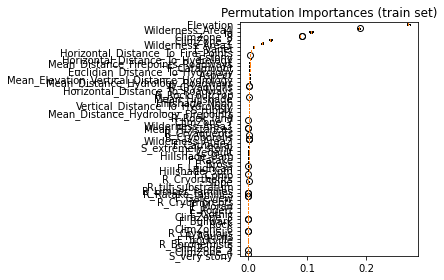

In [5]:
from sklearn.inspection import permutation_importance

X_train_enriched = cl.enrich_data(df_train)
X_train = X_train_enriched.drop(columns='Cover_Type')
y_train = X_train_enriched['Cover_Type']

feature_importances = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=2
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    feature_importances.importances[sorted_idx].T,
    vert=False,
    labels=X_train.columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

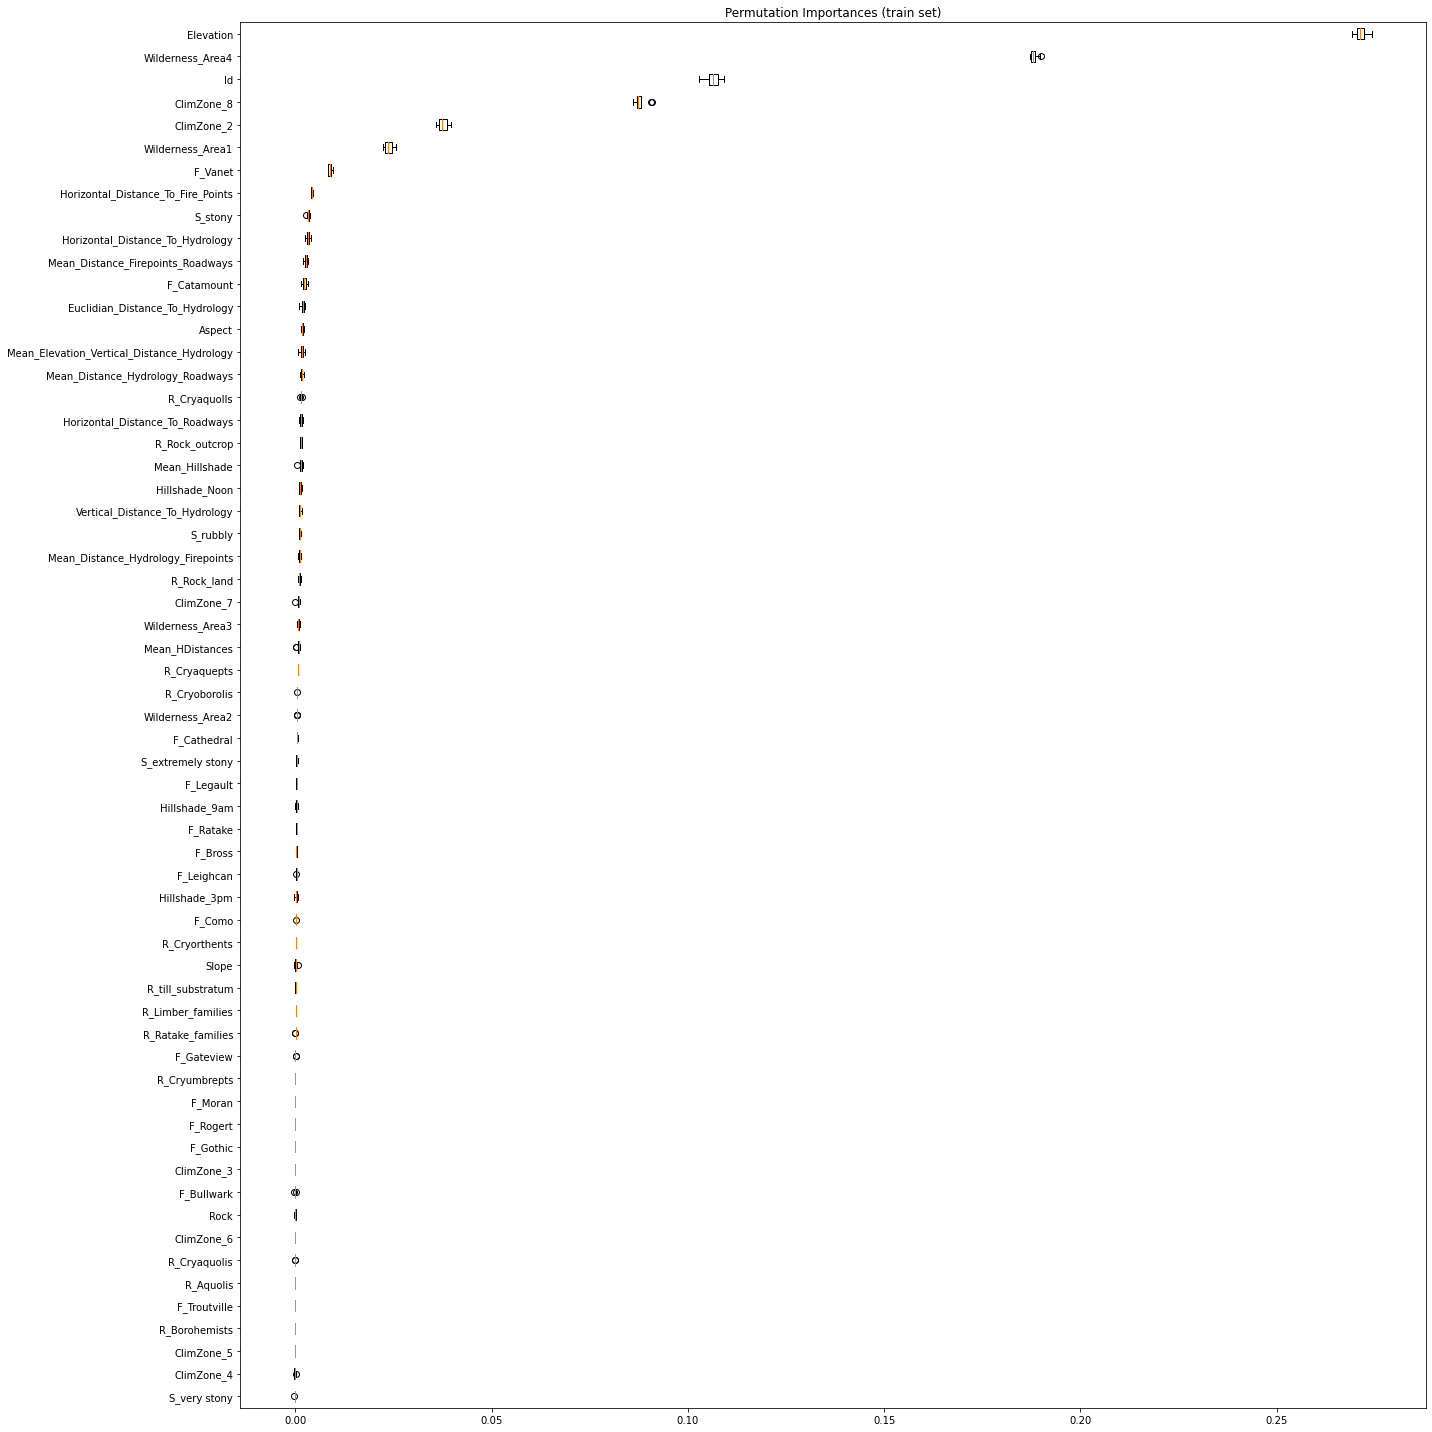

In [10]:
fig, ax = plt.subplots(figsize=(20,20))

ax.boxplot(
    feature_importances.importances[sorted_idx].T,
    vert=False,
    labels=X_train.columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

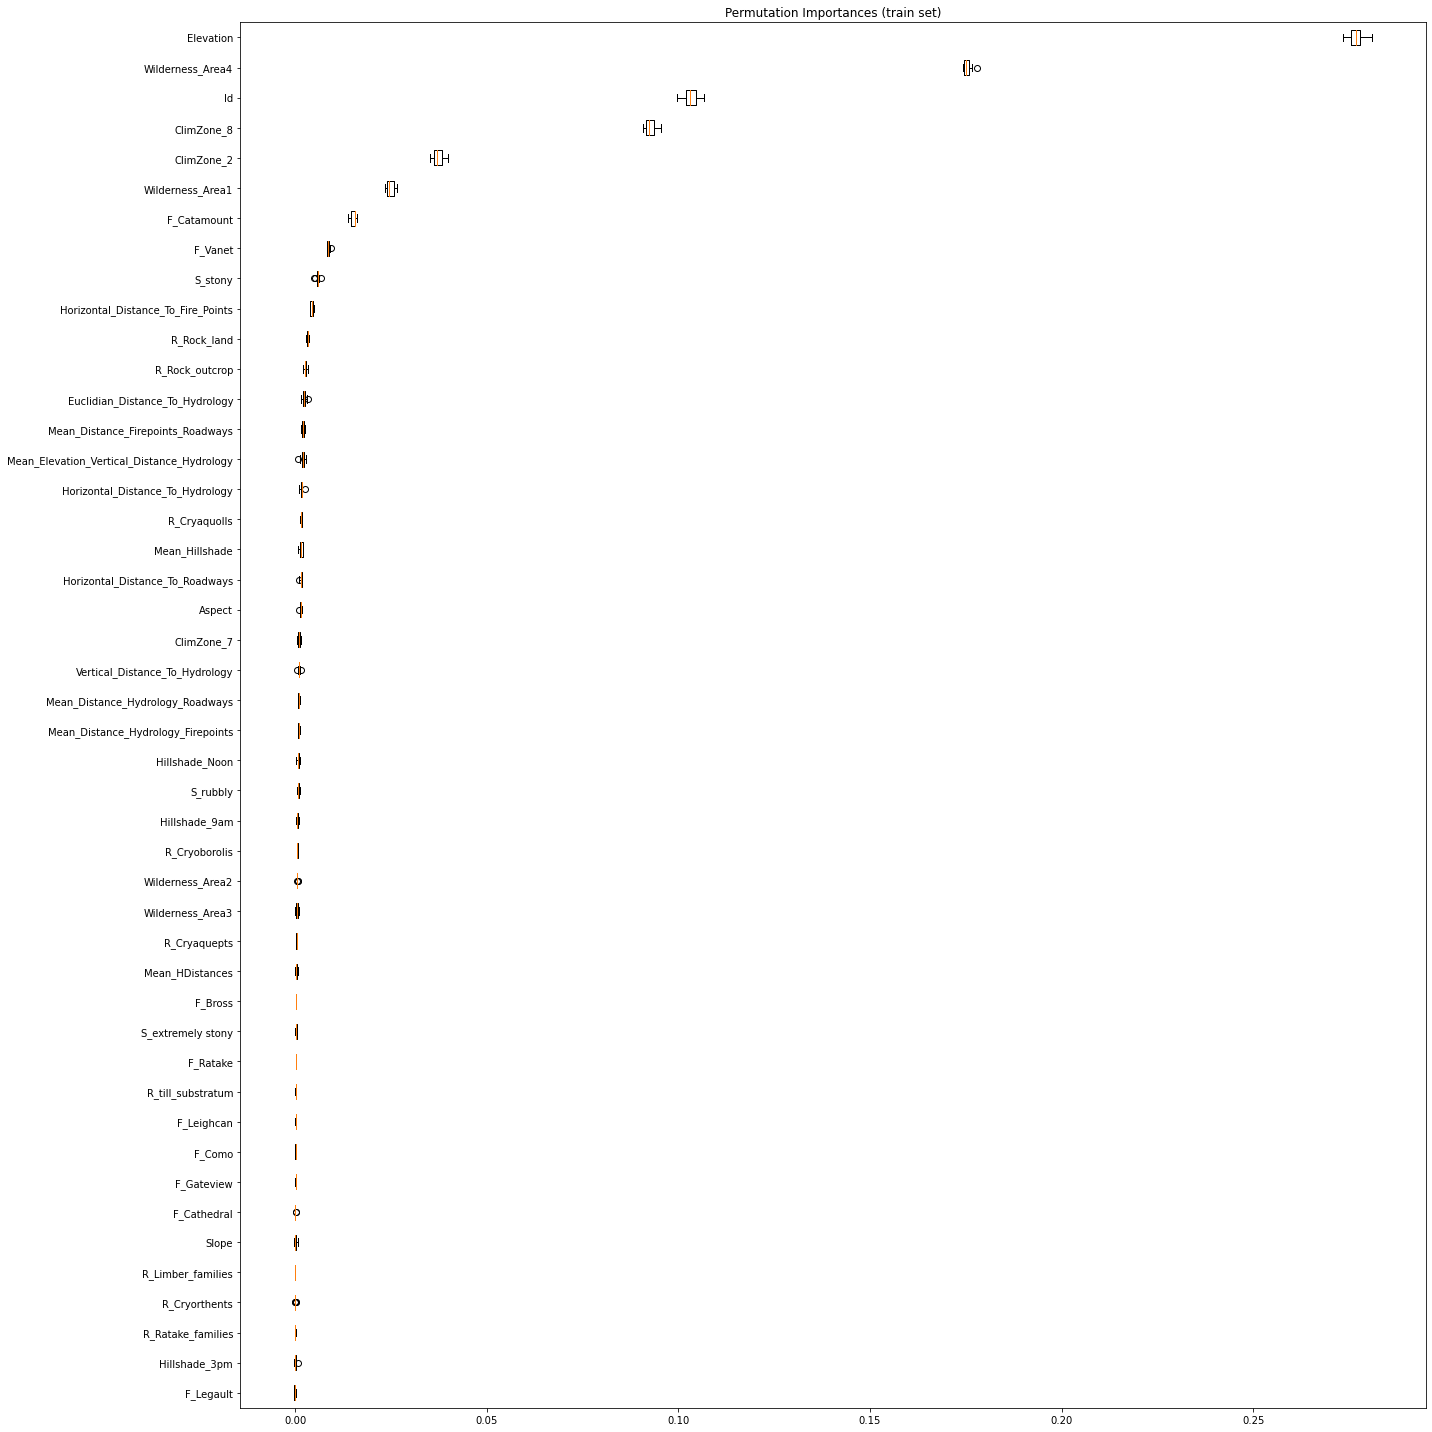

In [53]:
from sklearn.inspection import permutation_importance

X_train_enriched = cl.enrich_data(df_train)
X_train = X_train_enriched
y_train = df_train['Cover_Type']

feature_importances = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=2
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20,20))
ax.boxplot(
    feature_importances.importances[sorted_idx].T,
    vert=False,
    labels=X_train.columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [28]:
feature_importances.importances[sorted_idx]
feature_importances.importances_mean[sorted_idx][:15]

array([-9.92063492e-05, -9.25925926e-05, -6.61375661e-05, -6.61375661e-05,
       -6.61375661e-05, -6.61375661e-05, -5.29100529e-05, -4.62962963e-05,
       -6.61375661e-06, -6.61375661e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [39]:
significant_features = list(X_train.columns[sorted_idx][15:])

In [37]:
unsignificant_features = [col for col in all_columns if col not in significant_features and "Soil" not in col]

In [38]:
unsignificant_features

['Cover_Type']

In [40]:
all_columns

['Id',
 'Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4',
 'Soil_Type1',
 'Soil_Type2',
 'Soil_Type3',
 'Soil_Type4',
 'Soil_Type5',
 'Soil_Type6',
 'Soil_Type7',
 'Soil_Type8',
 'Soil_Type9',
 'Soil_Type10',
 'Soil_Type11',
 'Soil_Type12',
 'Soil_Type13',
 'Soil_Type14',
 'Soil_Type15',
 'Soil_Type16',
 'Soil_Type17',
 'Soil_Type18',
 'Soil_Type19',
 'Soil_Type20',
 'Soil_Type21',
 'Soil_Type22',
 'Soil_Type23',
 'Soil_Type24',
 'Soil_Type25',
 'Soil_Type26',
 'Soil_Type27',
 'Soil_Type28',
 'Soil_Type29',
 'Soil_Type30',
 'Soil_Type31',
 'Soil_Type32',
 'Soil_Type33',
 'Soil_Type34',
 'Soil_Type35',
 'Soil_Type36',
 'Soil_Type37',
 'Soil_Type38',
 'Soil_Type39',
 'Soil_Type40',
 'Cover_Type']

In [60]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier(learning_rate=0.01, max_depth=32, num_iteration=1024,num_leaves=512)
add_eng_features = True
add_climate = True
add_geographic = False
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
decomposition=None
columns_to_decomp=None
columns_to_drop = ['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls', 'Vertical_Distance_To_Hydrology'],
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 61
   -- took 54.03 sec
training model...
[LightGBM] [Warning] num_iterations is set=1024, num_iteration=1024 will be ignored. Current value: num_iterations=1024


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


   -- took 89.82 sec
predicting test_set...
   -- took 330.34 sec
exporting file...
computing local metrics...


/Users/camilleepitalon/miniconda3/envs/DS/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1024, num_iteration=1024 will be ignored. Current value: num_iterations=1024
   -- took 110.06 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(learning_rate=0.01, max_depth=32, num_iteration=1024,
               num_leaves=512), 'add_eng_features': True, 'add_climate': True, 'add_geographic': False, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': (['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls', 'Vertical_Distance_To_Hydrology'],), 'decomposition': None, 'columns_to_decomp': None, 'random_state': 2}
- Execution time: 584.92
- Accuracy: 0.914
- Confusion matrix:


,true6,true1,true5,true7,true2,true3,true4
pred6,376,43,0,0,5,0,19
pred1,52,330,9,0,18,6,2
pred5,0,4,370,11,3,23,0
pred7,0,0,4,430,0,2,0
pred2,0,10,4,0,398,1,0
pred3,0,0,26,11,2,419,0
pred4,5,0,0,0,0,0,441


In [63]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier(learning_rate=0.01, max_depth=-1, n_estimators=2048, num_leaves=1028)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = True
decomposition=None
columns_to_decomp=None
columns_to_drop = ['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'],
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 105
   -- took 79.37 sec
training model...
   -- took 320.03 sec
predicting test_set...
   -- took 671.01 sec
exporting file...
computing local metrics...
   -- took 222.59 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(learning_rate=0.01, n_estimators=2048, num_leaves=1028), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': True, 'columns_to_drop': (['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'],), 'decomposition': None, 'columns_to_decomp': None, 'random_state': 2}
- Execution time: 1293.98
- Accuracy: 0.9147
- Confusion matrix:


,true6,true1,true5,true7,true2,true3,true4
pred6,378,41,0,0,5,0,19
pred1,47,329,13,0,20,5,3
pred5,0,5,370,11,2,23,0
pred7,0,0,3,431,0,2,0
pred2,1,10,3,0,398,1,0
pred3,0,0,25,10,4,419,0
pred4,5,0,0,0,0,0,441


In [3]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier(learning_rate=0.01, max_depth=-1, n_estimators=2048, num_leaves=1028)
add_eng_features = True
add_climate = True
add_geographic = False
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
decomposition=None
columns_to_decomp=None
columns_to_drop = ['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'],
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 57
   -- took 75.12 sec
training model...
   -- took 336.91 sec
predicting test_set...
   -- took 1105.52 sec
exporting file...
computing local metrics...
   -- took 260.38 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(learning_rate=0.01, n_estimators=2048, num_leaves=1028), 'add_eng_features': True, 'add_climate': True, 'add_geographic': False, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': (['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'],), 'decomposition': None, 'columns_to_decomp': None, 'random_state': 2}
- Execution time: 1778.92
- Accuracy: 0.914
- Confusion matrix:


,true6,true1,true5,true7,true2,true3,true4
pred6,373,46,0,0,4,0,20
pred1,49,327,10,0,19,8,4
pred5,0,4,370,12,3,22,0
pred7,0,0,3,431,0,2,0
pred2,0,9,4,0,399,1,0
pred3,0,0,23,9,3,423,0
pred4,5,0,0,0,0,0,441


In [65]:
# Class parameters
df_train = df_train
df_test = df_test
model = LGBMClassifier(learning_rate=0.01, max_depth=-1, n_estimators=4096, num_leaves=2048, min_child_samples=10)
add_eng_features = True
add_climate = True
add_geographic = True
add_family = True
add_rocky = True
add_stony = True
keep_initial_rows = False
decomposition=None
columns_to_decomp=None
columns_to_drop = ['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'],
random_state = 2

cl = ClassifTools(df_train, df_test, model,
    add_eng_features,
    add_climate, add_geographic, add_family, add_rocky, add_stony,
    keep_initial_rows, columns_to_drop,
    None, None,
    random_state)

pred, acc, mat, pred_time = cl.test_predict(export_file=True, compute_local_metrics=True)
export_metrics(acc, mat, pred_time, cl)
print_results(acc, mat, pred_time, cl)

enriching the data...
number of features: 65
   -- took 69.83 sec
training model...
   -- took 328.36 sec
predicting test_set...
   -- took 1396.05 sec
exporting file...
computing local metrics...
   -- took 309.43 sec
> SUCCESS
-------------------------
- Parameters:  {'model': LGBMClassifier(learning_rate=0.01, min_child_samples=10, n_estimators=4096,
               num_leaves=2048), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': (['Id', 'ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls'],), 'decomposition': None, 'columns_to_decomp': None, 'random_state': 2}
- Execution time: 2104.4
- Accuracy: 0.9101
- Confusion matrix:


,true6,true1,true5,true7,true2,true3,true4
pred6,372,46,0,0,4,1,20
pred1,52,324,13,0,20,6,2
pred5,0,5,368,11,3,24,0
pred7,0,0,3,431,0,2,0
pred2,0,10,3,0,399,1,0
pred3,0,0,25,12,3,418,0
pred4,6,0,0,0,0,0,440


In [ ]:
{'model': LGBMClassifier(learning_rate=0.01, max_depth=32, num_iterations=1024, num_leaves=512), 'add_eng_features': True, 'add_climate': True, 'add_geographic': True, 'add_family': True, 'add_rocky': True, 'add_stony': True, 'keep_initial_rows': False, 'columns_to_drop': ['ClimZone_3', 'GeoZone_5', 'F_Gothic', 'F_Troutville', 'F_Rogert', 'F_Bross', 'R_Limber_families', 'R_Aquolis', 'R_Cryoborolis', 'R_Cryaquolis', 'R_Borohemists', 'R_Cryaquepts', 'R_Cryaquolls']

In [48]:
all_possible_columns = cl.enrich_data(df_train).columns
all_possible_columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm',
       ...
       'R_till_substratum', 'R_Cryaquepts', 'R_Cryumbrepts', 'R_Cryorthents',
       'R_Cryaquolls', 'Rock', 'S_rubbly', 'S_stony', 'S_very stony',
       'S_extremely stony'],
      dtype='object', length=106)

In [68]:
X_train_enriched = cl.enrich_data(df_train)

In [4]:
unsignificant_features = [col for col in all_possible_columns if col not in significant_features]
[col for col in unsignificant_features if 'Clim' in col]

NameError: name 'all_possible_columns' is not defined

In [93]:
X_train_enriched[[col for col in X_train_enriched.columns if 'Geo' in col]].sum()

GeoZone_1     1114
GeoZone_2     1078
GeoZone_5        3
GeoZone_7    12925
dtype: int64

In [72]:
X_test_enriched = cl.enrich_data(df_test)

In [73]:
X_test_enriched[[col for col in X_test_enriched.columns if 'Clim' in col]].sum()

ClimZone_2     35947
ClimZone_3       284
ClimZone_4     93593
ClimZone_5       602
ClimZone_6      8166
ClimZone_7    401983
ClimZone_8     40437
dtype: int64

In [96]:
X = X_train_enriched[X_train_enriched['GeoZone_1']==1]
C = X_train_enriched[X_train_enriched['GeoZone_2']==1]
Y = X_train_enriched[X_train_enriched['GeoZone_5']==1]
Z = X_train_enriched[X_train_enriched['GeoZone_7']==1]
for i in [1, 2, 3, 4, 5, 6, 7] :
    print(i, X[X['Cover_Type']==i]['Cover_Type'].count(), C[C['Cover_Type']==i]['Cover_Type'].count(),  Z[Z['Cover_Type']==i]['Cover_Type'].count())

1 78 596 1484
2 74 244 1841
3 53 0 2107
4 512 0 1648
5 193 141 1826
6 203 1 1956
7 1 96 2063


In [86]:
X = X_test_enriched[X_test_enriched['ClimZone_4']==1]
C = X_test_enriched[X_test_enriched['ClimZone_6']==1]
Y = X_test_enriched[X_test_enriched['ClimZone_2']==1]
Z = X_test_enriched[X_test_enriched['ClimZone_7']==1]
for i in [1, 2, 3, 4, 5, 6] :
    print(i, X[X['Cover_Type']==i]['Cover_Type'].count(), C[C['Cover_Type']==i]['Cover_Type'].count(), Y[Y['Cover_Type']==i]['Cover_Type'].count(), Z[Z['Cover_Type']==i]['Cover_Type'].count())

KeyError: 'Cover_Type'